In [1]:
from transformers import BertTokenizer, TFBertForQuestionAnswering
import tensorflow as tf
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
import numpy as np
import joblib
from tqdm import tqdm

c:\Users\charl\miniconda3\envs\mat099\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = BertTokenizer.from_pretrained("dmis-lab/biobert-base-cased-v1.1-squad")

In [3]:
model = TFBertForQuestionAnswering.from_pretrained("dmis-lab/biobert-base-cased-v1.1-squad", from_pt=True)

All PyTorch model weights were used when initializing TFBertForQuestionAnswering.

All the weights of TFBertForQuestionAnswering were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertForQuestionAnswering for predictions without further training.


In [4]:
# data = pd.read_csv("Data/clean_pmc.csv", nrows=1000)
data = joblib.load("outputs/data_june_5k.pkl")

In [5]:
not_null_data = data[data['abstract'].notnull()]
# not_null_data.reset_index(inplace=True, drop=True)

In [6]:
not_null_data.shape

(3425, 3)

In [7]:
def get_answer(question, text):
    
    inputs = tokenizer(question, text, return_tensors="tf")
    outputs = model(**inputs)
    answer_start_index = int(tf.math.argmax(outputs.start_logits, axis=-1)[0])
    answer_end_index = int(tf.math.argmax(outputs.end_logits, axis=-1)[0])
    predict_answer_tokens = inputs.input_ids[0, answer_start_index : answer_end_index + 1]
    predicted_answer = tokenizer.decode(predict_answer_tokens)

    return predicted_answer

In [18]:
question = "What are the risk factors of Covid-19?"

qa_results=[]
for index, row in tqdm(not_null_data[:500].iterrows(), total=not_null_data[:500].shape[0]):

    if len(tokenizer.tokenize(row['abstract'])) < 475:
        
        text = row['abstract']
        predicted_answer = get_answer(question=question, text=text)
        
        if predicted_answer != '[CLS]' and predicted_answer != '':
            qa_results.append((index, predicted_answer))

100%|██████████| 500/500 [25:06<00:00,  3.01s/it]


In [24]:
# joblib.dump(qa_results, 'outputs/bert_qa_results_june_500.pkl')
# qa_results = joblib.load('outputs/bert_qa_results_500.pkl')

['outputs/bert_qa_results_june_500.pkl']

In [19]:
# updated risk factors from word2vec
age_synonyms = ['age', 'younger', 'older', 'ages', 'aged', 'old']
gender_synonyms = ['gender', 'ethnicity', 'sex', 'demographics', 'occupation', 'nationality']
sex_synonyms = ['sex', 'gender', 'ethnicity', 'breed', 'race/ethnicity', 'occupation']
pneumonia_synonyms = ['pneumonia', 'pneumonias', 'tracheitis', 'croup', 'pharyngitis', 'bronchiolitis']
obesity_synonyms = ['obesity', 'diabetes', 'hypertension', 'malnutrition', 'osteoporosis', 'nafld']
diabetes_synonyms = ['diabetes', 'mellitus', 'obesity', 'hypertension', 'insulin-dependent', 'hypercholesterolemia']
smoking_synonyms = ['smoking', 'cigarette', 'smoke', 'obesity', 'abuse', 'breastfeeding']
cardiovascular_synonyms = ['cardiovascular', 'cardiopulmonary', 'cardiac', 'cerebrovascular', 'hypertension', 'musculoskeletal']
location_synonyms = ['location', 'locations', 'geographical', 'distribution', 'geographic', 'temporal']
contact_synonyms = ['contact', 'contacts', 'transmission', 'proximity', 'movement', 'exposure']
asthma_synonyms = ['asthma', 'wheezing', 'copd', 'exacerbations', 'atopy', 'wheeze']
cancer_synonyms = ['cancer', 'cancers', 'carcinoma', 'prostate', 'melanoma', 'tumour']

candidate_risk_factors = set(age_synonyms + gender_synonyms + sex_synonyms + pneumonia_synonyms + obesity_synonyms + diabetes_synonyms + smoking_synonyms + cardiovascular_synonyms + location_synonyms + contact_synonyms + asthma_synonyms + cancer_synonyms)

In [20]:
risk_factor_list=[]
for result in qa_results:
    for risk_factor in candidate_risk_factors:
        if risk_factor in result[1].split():
            risk_factor_list.append(risk_factor)

print(risk_factor_list)

['exposure', 'exposure', 'occupation', 'old', 'old', 'transmission', 'transmission', 'occupation', 'cancer', 'aged', 'pneumonia', 'pneumonia', 'hypertension']


In [21]:
risk_factor_count = Counter(risk_factor_list)
print(risk_factor_count)

Counter({'exposure': 2, 'occupation': 2, 'old': 2, 'transmission': 2, 'pneumonia': 2, 'cancer': 1, 'aged': 1, 'hypertension': 1})


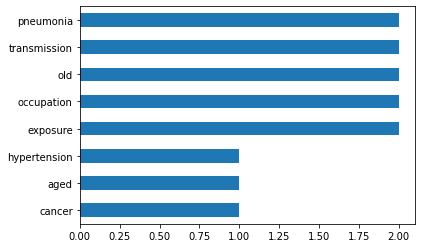

In [22]:
risk_factor_df = pd.DataFrame.from_dict(risk_factor_count, orient='index')
risk_factor_df.columns = ['count']
risk_factor_df.sort_values(by='count', ascending=True).plot(kind='barh', legend=None)
plt.show()